<a href="https://colab.research.google.com/github/Abdel-Moussaoui/Auto-Encoders/blob/master/image_denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
 - 10s - loss: 0.1798 - val_loss: 0.1278
Epoch 2/100
 - 3s - loss: 0.1210 - val_loss: 0.1125
Epoch 3/100
 - 3s - loss: 0.1124 - val_loss: 0.1082
Epoch 4/100
 - 3s - loss: 0.1081 - val_loss: 0.1090
Epoch 5/100
 - 3s - loss: 0.1056 - val_loss: 0.1024
Epoch 6/100
 - 3s - loss: 0.1038 - val_loss: 0.1019
Epoch 7/100
 - 3s - loss: 0.1027 - val_loss: 0.1020
Epoch 8/100
 - 3s - loss: 0.1019 - val_loss: 0.0996
Epoch 9/100
 - 3s - loss: 0.1010 - val_loss: 0.1000
Epoch 10/100
 - 3s - loss: 0.1005 - val_loss: 0.0995
Epoch 11/100
 - 3s - loss: 0.1001 - val_loss: 0.1000
Epoch 12/100
 - 3s - loss: 0.0999 - val_loss: 0.0991
Epoch 13/100
 - 3s - loss: 0.0994 - val_loss: 0.0991
Epoch 14/100
 - 3s - loss: 0.0992 - val_loss: 0.0981
Epoch 15/100
 - 3s - loss: 0.0989 - val_loss: 0.0980
Epoch 16/100
 - 3s - loss: 0.0986 - val_loss: 0.0977
Epoch 17/100
 - 3s - loss: 0.0984 - val_loss:

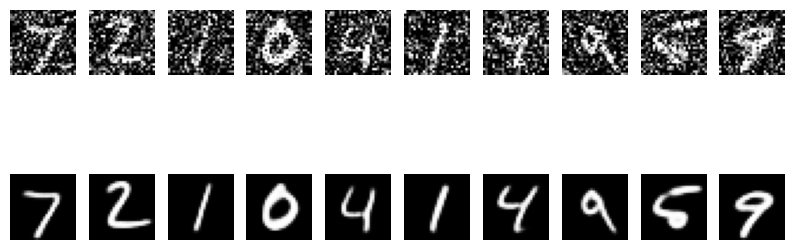

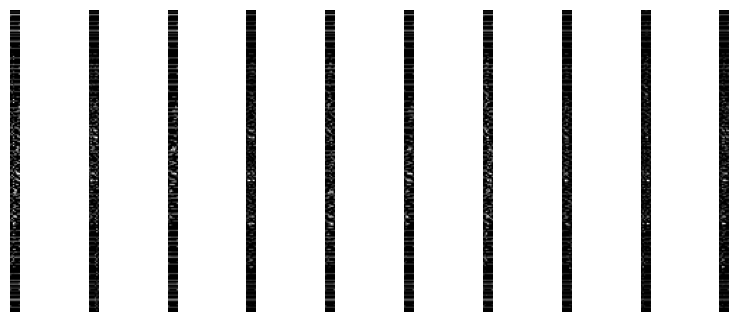

In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pickle

input_img = Input(shape=(28, 28, 1))    # adapt this if using 'channels_first' image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

# To train it, use the original MNIST digits with shape (samples, 3, 28, 28),
# and just normalize pixel values between 0 and 1

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))    # adapt this if using 'channels_first' image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))       # adapt this if using 'channels_first' image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# open a terminal and start TensorBoard to read logs in the autoencoder subdirectory
# tensorboard --logdir=autoencoder

autoencoder.fit(x_train_noisy, x_train, epochs=100, batch_size=128, shuffle=True,
                validation_data=(x_test_noisy, x_test), verbose=2,
                callbacks=[TensorBoard(log_dir='noisy', histogram_freq=0, write_grads=False)])

# take a look at the reconstructed digits
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    # display noisy
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.set_axis_off()

plt.show()

# take a look at the x-dimensional encoded representation
# these representations are 32x7x7, so we reshape them in order to be able to display them as grayscale images

encoder = Model(input_img, encoded)
encoded_imgs = encoder.predict(x_test)

# save latent space features 1568-d vector
pickle.dump(encoded_imgs, open('denoise_autoe_features.pickle', 'wb'))

n = 10
plt.figure(figsize=(10, 4), dpi=100)
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(7, 7 * 32).T)
    plt.gray()
    ax.set_axis_off()

plt.show()

K.clear_session()
